In [1]:
import os
import json
import torch
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vbf_tagger.tools.evaluation import general as g
from vbf_tagger.tools.visualization import classification as cv
from vbf_tagger.models.LorentzNet import classification
from vbf_tagger.tools.data.dataloaders import VBFDataModule
from sklearn.metrics import roc_curve, auc

with initialize(version_base=None, config_path="../config", job_name="test_app"):
    cfg = compose(config_name="main")

In [2]:
import torch
from omegaconf import DictConfig
torch.serialization.add_safe_globals([DictConfig])

ckpt_path = "/home/norman/vbf-tagger/outputs/pairs_5_vbfggfttsl/classification/models/model_best.ckpt"
checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

print(checkpoint.keys())                # top-level keys
print(checkpoint.get("hyper_parameters", None))  # what hyperparams contain


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hyper_parameters', 'datamodule_hparams_name', 'datamodule_hyper_parameters'])
{'n_scalar': 25, 'n_hidden': 128, 'n_class': 2, 'dropout': 0.1, 'n_layers': 4, 'c_weight': 0.001, 'verbosity': 1, 'lr': 0.001, 'pos_weight': 32.26826755852843}


In [3]:
import torch
from vbf_tagger.models.LorentzNet import classification

# Load checkpoint
ckpt_path = "/home/norman/vbf-tagger/outputs/pairs_5_vbfggfttsl/classification/models/model_best.ckpt"
checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

# Extract the hyperparameters dict
hyperparams = checkpoint["hyper_parameters"]

# Build model manually
model = classification(name="classification", hyperparameters=hyperparams)

# Load trained weights
model.load_state_dict(checkpoint["state_dict"])

# Put in eval mode
model.eval()


classification(
  (model): LorentzNet(
    (embedding): Linear(in_features=25, out_features=128, bias=True)
    (LGEBs): ModuleList(
      (0-2): 3 x LGEB(
        (phi_e): Sequential(
          (0): Linear(in_features=258, out_features=128, bias=False)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=128, out_features=128, bias=True)
          (4): ReLU()
        )
        (phi_h): Sequential(
          (0): Linear(in_features=281, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=128, out_features=128, bias=True)
        )
        (phi_x): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=1, bias=False)
        )
        (phi_m): Sequential(
          

In [10]:
cfg = OmegaConf.load("/home/norman/vbf-tagger/vbf_tagger/config/training.yaml")

# Add dataset info manually
cfg.dataset = {
    "data_dir": "/home/norman/vbf-tagger/vbf_tagger/data/22pre/hh_vbf/preprocessed_filtered/",
    "train_dir": "train",
    "val_dir": "val",
    "test_dir": "test"
}

dm = VBFDataModule(cfg=cfg, data_type="val", device="cpu")
dm.setup(stage="fit")
val_loader = dm.val_dataloader()

batch = next(iter(val_loader))
print(type(batch), len(batch))


There are 294,759 waveforms/events/jets in the dataset.
There are 84,202 waveforms/events/jets in the dataset.
[INFO] Computed pos_weight = 15.613 from training data
<class 'list'> 4


In [11]:
print(hyperparams)

{'n_scalar': 25, 'n_hidden': 128, 'n_class': 2, 'dropout': 0.1, 'n_layers': 4, 'c_weight': 0.001, 'verbosity': 1, 'lr': 0.001, 'pos_weight': 15.613338892716}


In [12]:
with torch.no_grad():
    preds, targets, mask = model(batch)   # preds: (B, P, 2), targets: (B, P), mask: (B, P, 1)

# Remove beams (first 2 candidates)
preds = preds[:, 2:, :]     # (B, P, 2)
targets = targets   # (B, P)
mask = mask      # (B, P)

# Flatten
B, P, C = preds.shape
preds = preds.reshape(B * P, C)      # (B*P, 2)
targets = targets.reshape(B * P)     # (B*P,)
mask = mask.reshape(B * P).bool()    # (B*P,)

# Apply mask
preds = preds[mask, :]
targets = targets[mask]

# Probabilities
probs = torch.softmax(preds, dim=-1)[:, 1]
y_score = probs.cpu().numpy()
y_true  = targets.cpu().numpy()

print("y_score:", y_score.shape)
print("y_true:", y_true.shape)




y_score: (2464,)
y_true: (2464,)


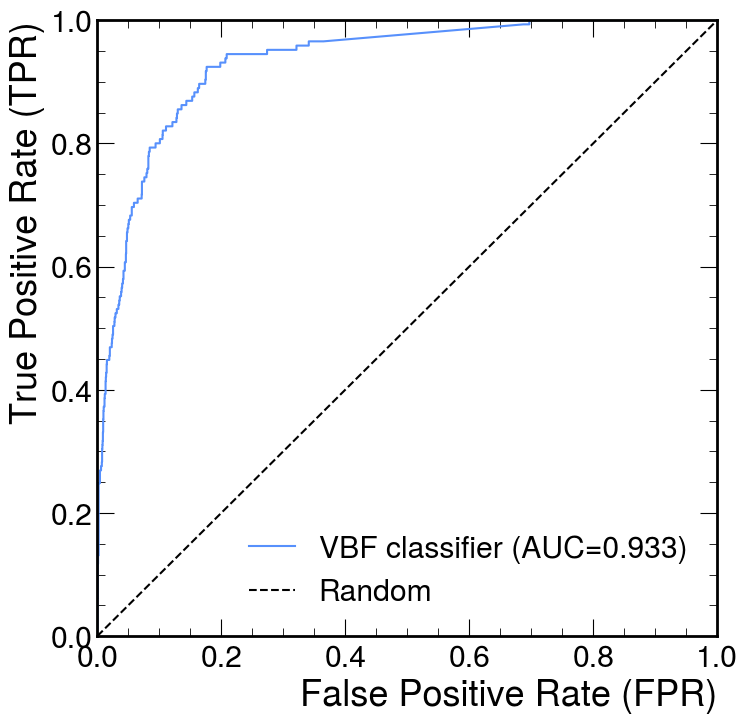

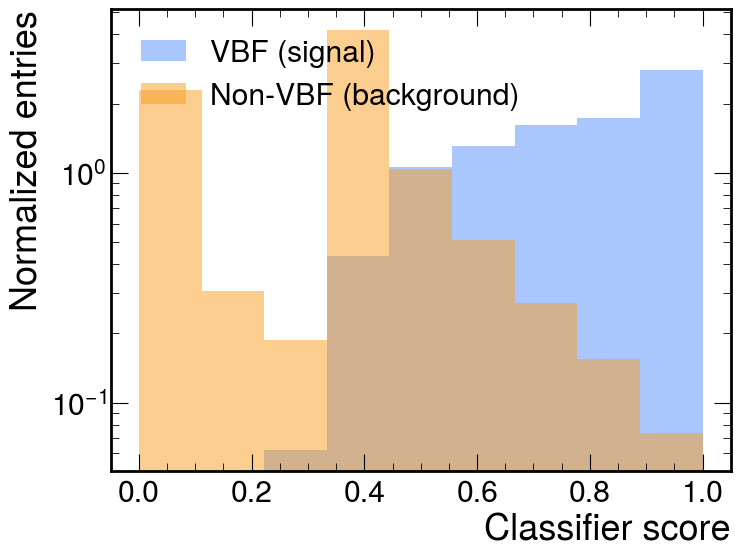

In [14]:
roc_plot = cv.VBFROCPlot()
roc_plot.plot(y_true, y_score, label="VBF classifier")

# -------------------
# 4. Plot classifier score histogram
# -------------------
score_hist = cv.VBFScoreHistogram(num_bins=10)
score_hist.plot(y_true, y_score)